# <center> EOM DAC Channel

Makes a CW output by using periodic mode, which has been used in the example above. The idea is to have both DACs outputting the same frequency, but with a different phase that can be set by the user.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.parser import load_program

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from create_json import import_json_file, save_list_to_json_file

config = import_json_file("config.json")

In [3]:
# Load bitstream with custom overlay
soc = QickSoc()
soccfg = soc
# print(soccfg)

# Print the QICK configuration
print(soc)

# loopback and monitor channels
out_chs = [0,1]


QICK configuration:

	Board: RFSoC4x2

	Global clocks (MHz): tProcessor 350.000, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 0, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=614.400 MHz, fs=9830.400 MHz

	2 readout channels:
	0:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, ch 0, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 4, tProc input 0
	1:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, ch 1, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 5, tProc input 1

	2 DACs:
		DAC tile 0, ch 0 is DAC_B
		DAC tile 2, ch 0 is DAC_A

	2 ADCs:
		ADC tile 0, ch 0 is ADC_D
		ADC tile 0, ch 1 is ADC_C

	4 digital output pins (tProc output 7):
	0:	PMOD0_0
	1:	PMOD0_1
	2:	PMOD0_2
	3

In [4]:
# Output frequency f0_v.
###################
# Try it yourself ! Change the output frequency.
###################

f0_start=1003
f0_step=0.000250
expts=40
# expts=1

f0_v = np.arange(0,expts)*f0_step+f0_start

f0_v = soccfg.adcfreq(f0_v, gen_ch=0, ro_ch=0)

def calculate_phase(d):
    [xi,xq] = d
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.mean(x)

    # Calculate calibration phase.
    fi = np.remainder(np.angle(xavg,deg=True)+360,360)
    return [fi, np.abs(xavg), np.std(x)]

def print_results(f0, res):
    print("freq_i = %f MHz, \n"%(f0) +
         "phi_i = (%.2f, %.2f) deg, \n" % tuple([res[i][0] for i in range(2)]) +
         "mag = (%.2f, %.2f), \n" % tuple([res[i][1] for i in range(2)]) +
         "RMS = (%.2f, %.2f) ADU" % tuple([res[i][2] for i in range(2)]))
#     print("freq_i = %f MHz, phi_i = (%.2f, %.2f) deg, mag = (%.2f, %.2f), RMS = (%.2f, %.2f) ADU" %(f0,*out_array,*A,*xrms))

In [5]:
class MultipleFreqProgram(AveragerProgram):
    def __init__(self,soccfg, cfg):
        super().__init__(soccfg, cfg)

    def initialize(self):
        cfg=self.cfg   
        
        # configure the readout lengths and downconversion frequencies
        for ch in range(2):
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"])

        idata = 30000*np.ones(16*cfg["length"])
#         qdata = 30000*np.ones(16*cfg["length"])

        for ch in self.cfg['out_ch']:
            self.declare_gen(ch=ch, nqz=cfg["zone"])
            self.add_pulse(ch=ch, name="measure", idata=idata)
#             self.add_pulse(ch=ch, name="measure", idata=idata,qdata=qdata)
        
        freq=soccfg.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency
#         self.trigger(pins=[0], t=0) # send a pulse on pmod0_0, for scope trigger
        for ii, ch in enumerate(self.cfg['out_ch']):
            self.default_pulse_registers(ch=ch,style="arb",waveform="measure", mode=cfg["mode"])
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ii, ch in enumerate(self.cfg['out_ch']):
            for jj,freq in enumerate(self.cfg["freq_seq"]):
                self.set_pulse_registers(ch=ch, freq=soccfg.freq2reg(self.cfg[freq]["pulse_freq"]), phase=soccfg.deg2reg(self.cfg[freq]["res_phase"]), gain=self.cfg[freq]["pulse_gain"])
                self.pulse(ch=ch, t=self.cfg["time_seq"][jj]) # play readout pulse
        self.wait_all() # control should wait until the readout is over
        self.sync_all(200)  # wait for measurement to complete


  0%|          | 0/1 [00:00<?, ?it/s]

freq_i = 999.999998 MHz, 
phi_i = (10.14, 254.04) deg, 
mag = (39.05, 38.81), 
RMS = (40.18, 39.88) ADU
Phase difference of -243.909677890439 deg


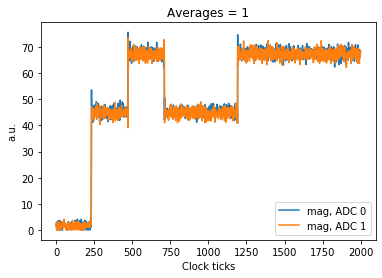

In [6]:
prog = MultipleFreqProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
save_list_to_json_file(iq_list, "iq_list.json")

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
#     plt.plot(iq[0], label="I value, ADC %d"%(config['out_ch'][ii]))
#     plt.plot(iq[1], label="Q value, ADC %d"%(config['out_ch'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['out_ch'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()


# to switch off output
soc.reset_gens()


# get the phase
res = [calculate_phase(iq) for iq in iq_list]
print_results(config['pulse_freq'], res)

p_diff = res[0][0]-res[1][0]
print('Phase difference of {:} deg'.format(p_diff))

# if config['res_phase'] == [0, 0]:
#     p_diff0 = p_diff.copy() 


In [9]:
freqA = {"res_phase": 90 , # The phase of the signal        

        "pulse_gain": 2000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": soccfg.adcfreq(1000, gen_ch=0, ro_ch=0), # [MHz]
        }
freqB = {"res_phase": 180 , # The phase of the signal        

        "pulse_gain": 3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": soccfg.adcfreq(1000, gen_ch=0, ro_ch=0), # [MHz]
        }
A = "freqA"
B = "freqB"
config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "freqA": freqA,
        "freqB": freqB,
        "freq_seq": [A,B,A,B],
#         "res_phase": [180 ,180],
#         "pulse_gain":[32000,32000],
        "time_seq":[50, 190,370,700],
        # pulse length: will be repeated periodically
        "length":100, # [Clock ticks]
        "pulse_freq":soccfg.adcfreq(1000, gen_ch=1, ro_ch=1), #readout freq
        "readout_length": 2000, # [Clock ticks]
        

        "adc_trig_offset": 0, # [Clock ticks]
        # Needs to be > 150 to avoid seeing the rising pulse flank

        "soft_avgs":1,
        # Try varying soft_avgs from 1 to 200 averages
        
        "zone": 1,  
        # nyquist zone of generator
        
        
        "mode": "periodic",
        # to make CW output
        
        
        #"mode": "oneshot"
        # to make single shot output

       }

In [10]:
from create_json import create_json

create_json(config)


In [7]:
iq_list

array([[[  0.,  -1.,   0., ...,  48.,  47.,  47.],
        [ -2.,  -1.,  -1., ..., -48., -47., -47.]],

       [[ -2.,   0.,   1., ..., -64., -67., -64.],
        [ -1.,  -2.,  -1., ..., -21., -22., -24.]]])

In [20]:
freqA = {"res_phase": 90 , # The phase of the signal        

        "pulse_gain": 2000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": soccfg.adcfreq(1000, gen_ch=0, ro_ch=0), # [MHz]
        }
freqB = {"res_phase": 180 , # The phase of the signal        

        "pulse_gain": 3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": soccfg.adcfreq(1000, gen_ch=0, ro_ch=0), # [MHz]
        }
A = "freqA"
B = "freqB"
config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "freqA": freqA,
        "freqB": freqB,
        "freq_seq": [A,B,A,B],
#         "res_phase": [180 ,180],
#         "pulse_gain":[32000,32000],
        "time_seq":[50, 190,370,700],
        # pulse length: will be repeated periodically
        "length":100, # [Clock ticks]
        "pulse_freq":soccfg.adcfreq(1000, gen_ch=0, ro_ch=0), #readout freq
        "readout_length": 2000, # [Clock ticks]
        

        "adc_trig_offset": 0, # [Clock ticks]
        # Needs to be > 150 to avoid seeing the rising pulse flank

        "soft_avgs":1,
        # Try varying soft_avgs from 1 to 200 averages
        
        "zone": 1,  
        # nyquist zone of generator
        
        
        "mode": "periodic",
        # to make CW output
        
        
        #"mode": "oneshot"
        # to make single shot output

       }

  0%|          | 0/1 [00:00<?, ?it/s]

freq_i = 999.999998 MHz, 
phi_i = (55.70, 222.64) deg, 
mag = (38.97, 38.92), 
RMS = (40.09, 39.96) ADU
Phase difference of -166.93691804381118 deg


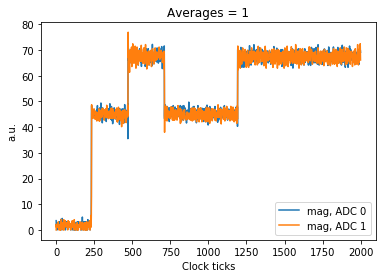

In [21]:
prog = MultipleFreqProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
#     plt.plot(iq[0], label="I value, ADC %d"%(config['out_ch'][ii]))
#     plt.plot(iq[1], label="Q value, ADC %d"%(config['out_ch'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['out_ch'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()


# to switch off output
soc.reset_gens()


# get the phase
res = [calculate_phase(iq) for iq in iq_list]
print_results(config['pulse_freq'], res)

p_diff = res[0][0]-res[1][0]
print('Phase difference of {:} deg'.format(p_diff))

# if config['res_phase'] == [0, 0]:
#     p_diff0 = p_diff.copy() 


In [51]:
# config={"out_ch":out_chs,
#         "reps":1, # --Fixed
#         "res_phase": [0,0] , # The phase of the signal
        
#         # pulse length: will be repeated periodically
#         "length":500, # [Clock ticks]
        
#         "readout_length":400, # [Clock ticks]
        

#         "pulse_gain": [32000, 32000], # [DAC units]
#         # Try varying pulse_gain from 500 to 30000 DAC units

#         "pulse_freq": 1003, # [MHz]

#         "adc_trig_offset": 170, # [Clock ticks]
#         # Needs to be > 150 to avoid seeing the rising pulse flank

#         "soft_avgs":1,
#         # Try varying soft_avgs from 1 to 200 averages
        
#         "zone": 1,  
#         # nyquist zone of generator
        
        
#         "mode": "periodic",
#         # to make CW output
        
        
#         #"mode": "oneshot"
#         # to make single shot output

#        }

In [10]:
# to switch off output
soc.reset_gens()